# Testing phase differences
This notebook analyzes the differences in phases of noisy input and the denoised target output.

A detailed analysis of this question can serve the ultimate goal of trying to find the optimal representation of the data: is it actually necessary to fit the amplitude and the phase or is the phase difference resulting from denoising neglectable?


## Imports
This notebook uses the custom code found in the code folder

In [1]:
import os

# math, processing, deep learning
import numpy as np
import tensorflow as tf
from scipy.signal import stft, istft

# visualization
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable


# custom code
from code.stftprocessing import StftDataset
from code.dsvisual import DatasetVisualizer

# convenience
from tqdm import tqdm
import datetime


2023-05-04 14:31:40.063945: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load the files for training and testing
There are different training and test sets in the folder. This section loads the appropriate ones into memory.


In [2]:
# this is a smaller training set for testing purposes
folder = "training/new_small"
base = "noisy_small"
target = "pure_small"

# this is a training set for training the main model
# folder = "training/original training"
# base = "noisy"
# target = "pure"

test_folder = "training/test set"
test_base = "noisy_test"
test_target = "pure_test"


Load the files from the given locations using the custom code StftDataset class.

The StftDataset class also processes the waveforms into STFT format.

In [3]:
noisy_stft = StftDataset()
pure_stft = StftDataset()

noisy_stft.load(folder, base)
pure_stft.load(folder, target)

# test sets
noisy_test_stft = StftDataset()
pure_test_stft = StftDataset()
noisy_test_stft.load(test_folder, test_base)
pure_test_stft.load(test_folder, test_target)

Files loaded.
Files loaded.
Files loaded.
Files loaded.


### Extracting phase information
The StftDataset class loads the data that was stored in amplitude and phase format in different files and combines it together

In [4]:
# get the phases of training and test sets
noisy_amplitudes = noisy_stft.get_data()[:,:,:,0]
noisy_phases = noisy_stft.get_data()[:,:,:,1]
pure_amplitudes = pure_stft.get_data()[:,:,:,0]
pure_phases = pure_stft.get_data()[:,:,:,1]


## Recalculation of waveforms
The waveforms are calculated from inverse STFTs.

In [5]:
t, pure_waveforms = istft(pure_amplitudes * np.exp(1j*pure_phases))
t, noisy_waveforms = istft(noisy_amplitudes * np.exp(1j*noisy_phases))
t, mixed_waveforms = istft(pure_amplitudes * np.exp(1j*noisy_phases))

## Visualization of STFT
The STFTs from the loaded data will be visualized in this section


In [6]:
example_index_stft = 0

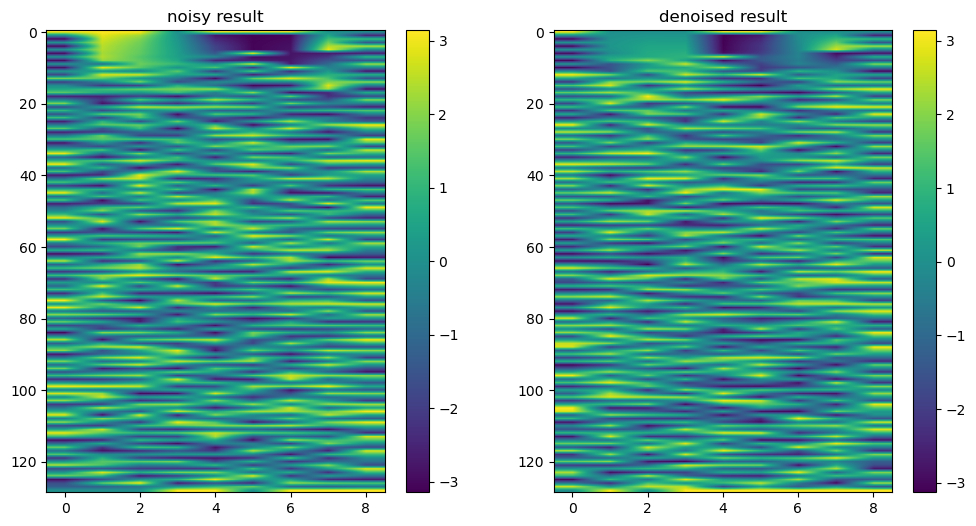

In [7]:
fig, [ax1, ax2] = plt.subplots(1,2)
# fig.set_size_inches(10,8)
ax1.set_title("noisy result")
ax2.set_title("denoised result")
im1 = ax1.imshow(noisy_phases[example_index_stft], aspect="auto", interpolation="bilinear")
im2 = ax2.imshow(pure_phases[example_index_stft], aspect="auto", interpolation="bilinear")
plt.colorbar(im1)
plt.colorbar(im2)

fig.set_size_inches(12,6)
plt.show()

# plt.colorbar()

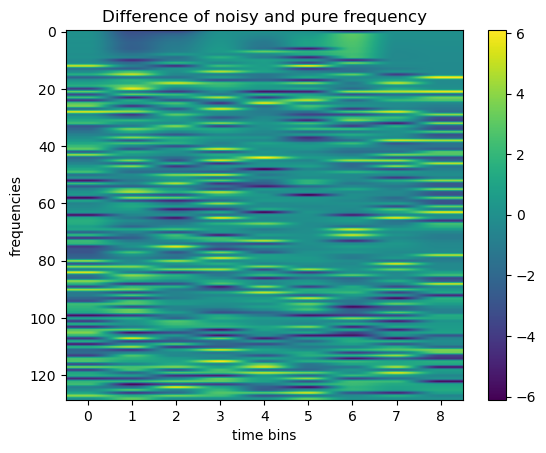

In [8]:
plt.imshow(pure_phases[0]-noisy_phases[0], aspect="auto")
plt.colorbar()
plt.title("Difference of noisy and pure frequency")
plt.ylabel("frequencies")
plt.xlabel("time bins")
plt.show()

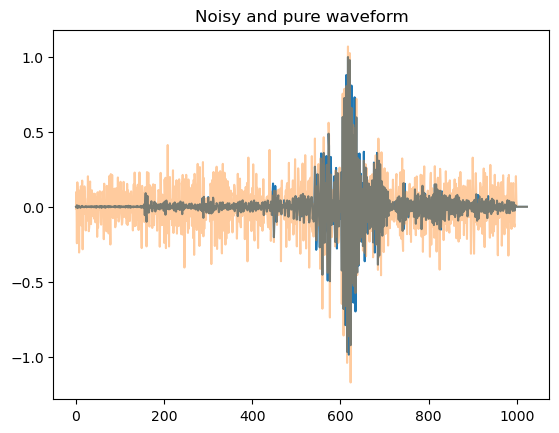

In [9]:
plt.plot(pure_waveforms[1])
plt.plot(noisy_waveforms[1], alpha=0.4)
plt.title("Noisy and pure waveform")
plt.show()

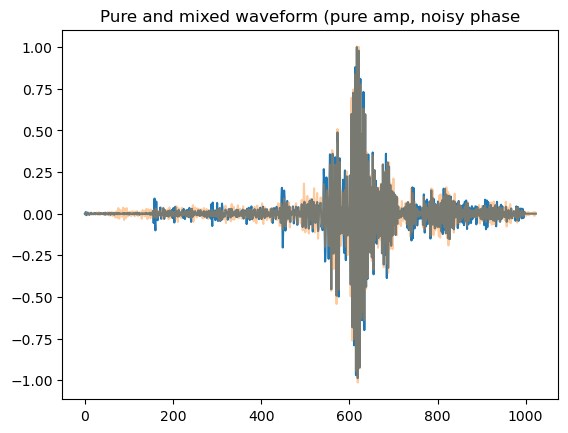

In [10]:
plt.title("Pure and mixed waveform (pure amp, noisy phase")
plt.plot(pure_waveforms[1])
plt.plot(mixed_waveforms[1], alpha=0.4)
plt.show()

## Assessing the waveforms
Pure waveforms and mixed waveforms.

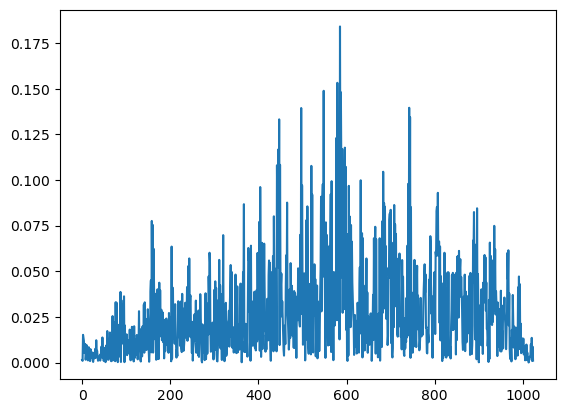

In [11]:
plt.plot(np.abs(pure_waveforms[1]-mixed_waveforms[1]))


In [12]:
np.mean(np.abs(pure_waveforms[1]-mixed_waveforms[1]))

0.02742314337902613

In [13]:
diff_mixed_pure = pure_waveforms-mixed_waveforms
absolute_difference = np.abs(diff_mixed_pure) 

In [14]:
absolute_difference.shape

(10000, 1024)

### Get the upper 10% of difference
The upper 10% percentile gives a good estimate of the difference. This percentile represents the highest difference of the 2 waveforms. Later comparison with the full mean show very little qualitative difference of this assessment versus the full mean.

In [15]:
upper10_threshold = np.quantile(absolute_difference, [0.9], axis=1)
upper10_threshold = upper10_threshold.reshape(upper10_threshold.shape[1])
upper10_values = []
for i in range(absolute_difference.shape[0]):
    # print(i, values)
    new_value = absolute_difference[i][absolute_difference[i] > upper10_threshold[i]]
    upper10_values.append(new_value)
upper10_values =np.array(upper10_values)

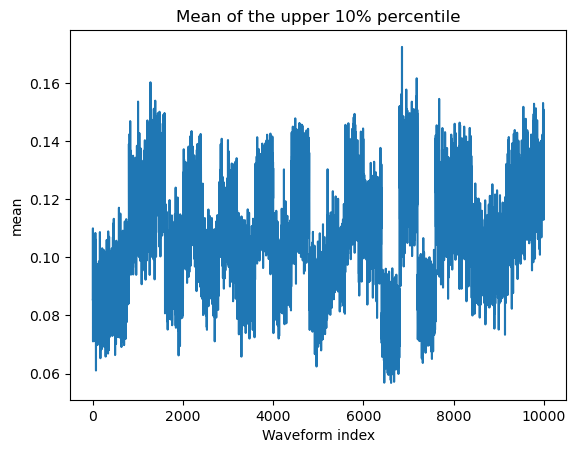

In [16]:
plt.plot(upper10_values.mean(axis=1))
plt.title("Mean of the upper 10% percentile")
plt.xlabel("Waveform index")
plt.ylabel("mean")
plt.show()

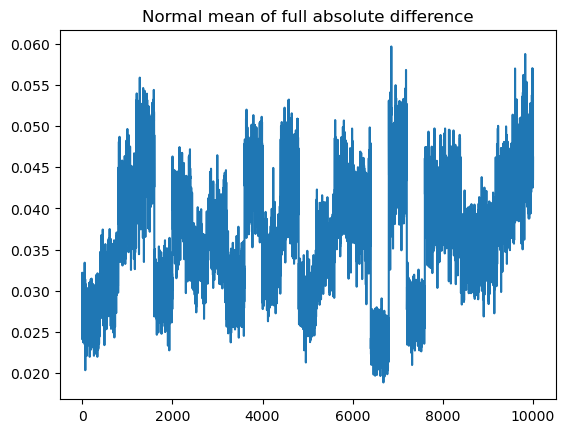

In [17]:
plt.title("Normal mean of full absolute difference")
plt.plot(absolute_difference.mean(axis=1))
plt.show()

### Assessment using the variance
Using the variance of the difference between the pure and the mixed waveforms.

In [18]:
var_diff = np.var(diff_mixed_pure, axis=1)

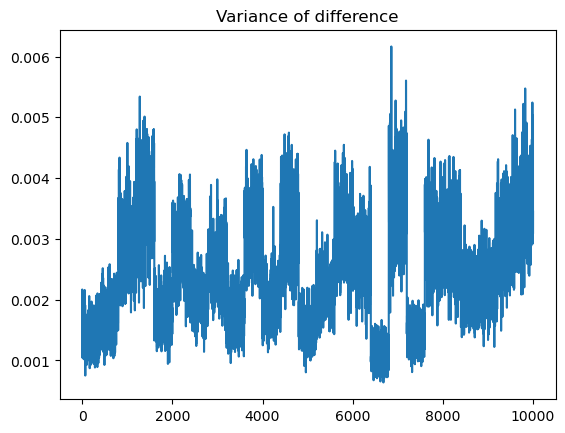

In [19]:
plt.plot(var_diff)
plt.title("Variance of difference")
plt.show()

There is almost no dicernible difference in the distribution of the data when looking at variance of the difference or mean of the (absolute) difference.

### Maximum of difference between waveforms
The maximum is a different metric. It is not directly dependent on the full range of the data and does not take each value into account.


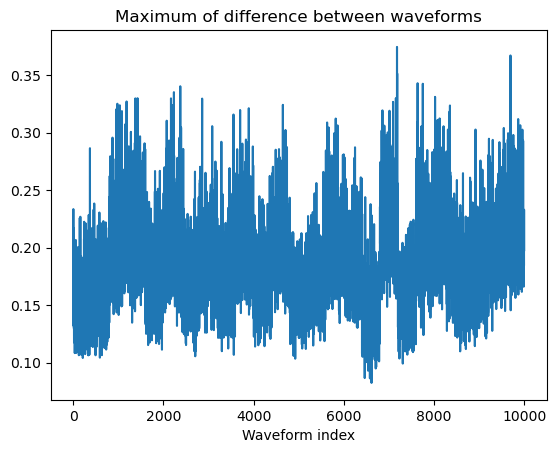

In [20]:
plt.plot(np.max(diff_mixed_pure, axis=1))
plt.title("Maximum of difference between waveforms")
plt.xlabel("Waveform index")
plt.show()

## Effect on highest percentile
The previous analysis only looked at the upper 10% percentile of the difference of the waveforms. Separating the original waveform into percentiles before that is a different measurement.

The most relevant parts of the waveform signal are higher amplitude parts of the recording. Arguably, the high amplitude parts are the **only** "real" parts of the signal. 

Therefore, looking at what happens to these parts of the signal might be a better metric.

In [21]:
# look at the pure waveforms
@interact(index=(0,10000-1))
def plot_showcase(index):
    showcase_waveform= pure_waveforms[index]
    plt.plot(showcase_waveform)

interactive(children=(IntSlider(value=4999, description='index', max=9999), Output()), _dom_classes=('widget-i…

In [22]:
# look at the pure waveforms
@interact(index=(0,10000-1))
def plot_quantile_waveform(index):
    showcase_waveform= pure_waveforms[index]
    
    threshold33 = np.quantile(np.abs(showcase_waveform), 0.7)

    # np.where(showcase_waveform > threshold33)
    indices33 = np.nonzero(np.abs(showcase_waveform) > threshold33)[0]

    selected_waveform33 = showcase_waveform[indices33]

    plt.plot(indices33, selected_waveform33, ".")
    plt.plot(showcase_waveform, alpha=0.4)

interactive(children=(IntSlider(value=4999, description='index', max=9999), Output()), _dom_classes=('widget-i…

In [23]:
def calculate_quantile_difference(waveform1, waveform2, quantile=0.66):
    """ This function calculates the difference 
    between two waveforms of only those values
    in the given quantile.
    The parameter waveform1 is the one from
    which the indices of the quantile will be
    chosen
    
    params
    waveform1:: np.array
    waveform2:: np.array
    quantile:: float
    """
    # get the threshold value using the given quantile    
    threshold = np.quantile(np.abs(waveform1), quantile)
    # 
    indices = np.nonzero(np.abs(waveform1) > threshold)[0]

    selected_values1 = waveform1[indices]
    selected_values2 = waveform2[indices]
    
    difference = selected_values1 - selected_values2
    
    return difference


In [24]:
test_dif = calculate_quantile_difference(pure_waveforms[0], noisy_waveforms[0], quantile=0.66)

In [25]:
# define the two sets of waveforms to be compared
base_waveforms = pure_waveforms
comparison_waveforms = mixed_waveforms

high_level_difference = []
for i in range(pure_waveforms.shape[0]):
    current_diff =calculate_quantile_difference(base_waveforms[i], comparison_waveforms[i], quantile=0.66)
    high_level_difference.append(current_diff)
high_level_difference = np.array(high_level_difference)

In [26]:
high_level_difference_mean = np.abs(high_level_difference).mean(axis=1)
high_level_difference_max = np.abs(high_level_difference).max(axis=1)
high_level_difference_var = np.abs(high_level_difference).var(axis=1)

In [27]:
class StftComparison(object):
    def __init__(self, pure_waveforms, noisy_waveforms):
        
        high_level_difference = []
        # calculate the differences of each
        for i in range(pure_waveforms.shape[0]):
            current_diff =calculate_quantile_difference(pure_waveforms[i], noisy_waveforms[i], quantile=0.66)
            high_level_difference.append(current_diff)
        self.difference = np.array(high_level_difference)

        self.difference_mean = np.abs(self.difference).mean(axis=1)
        self.difference_max = np.abs(self.difference).max(axis=1)
        self.difference_var = np.abs(self.difference).var(axis=1)



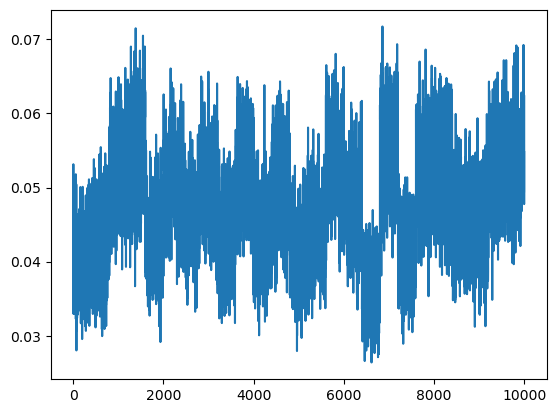

In [28]:
plt.plot(high_level_difference_mean)

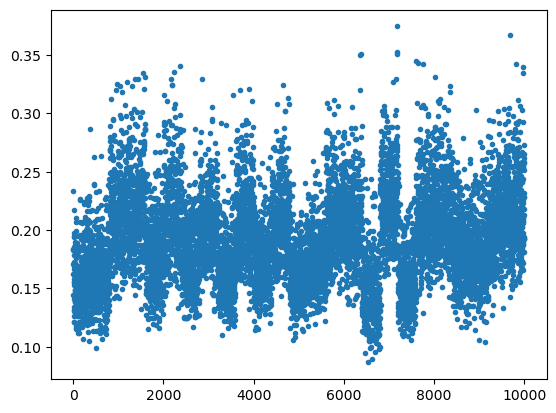

In [29]:
plt.plot(high_level_difference_max,".")

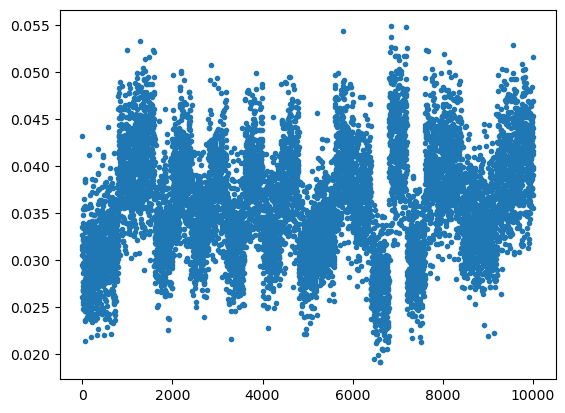

In [30]:
plt.plot(np.sqrt(high_level_difference_var),".")

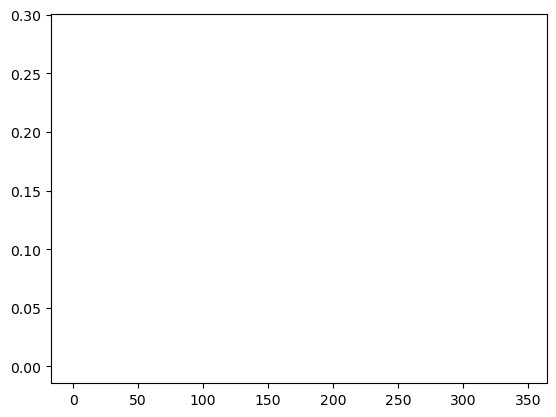

In [31]:
plt.plot(np.abs(high_level_difference)[:500].T, color="blue", alpha=0.001)
plt.show()

In [32]:
np.abs(test_dif).mean()

0.0944655479744733

## Analyze effect of time bins
Potentially, the amount of different time bins might affect the strength of the error of the phase.

If there are more time bins, i.e. the waveform is split into more fine grained parts, this might lead to either smaller changes in the phase from noisy to denoised result as well as less importance of the error of the phase overall.

Steps:
- Recalculate STFT with different amount of time bins 
- Calculate difference of high values
- Analyze difference of these values

In [33]:
# todo: recalculate STFT with different time bin

In [34]:
test_waveform = pure_waveforms[0]

In [35]:
f,t, stft_result = stft(test_waveform, fs=5., nperseg=64)

In [36]:
stft_result.shape

(33, 33)

In [37]:
stft_result_amp = np.abs(stft_result)

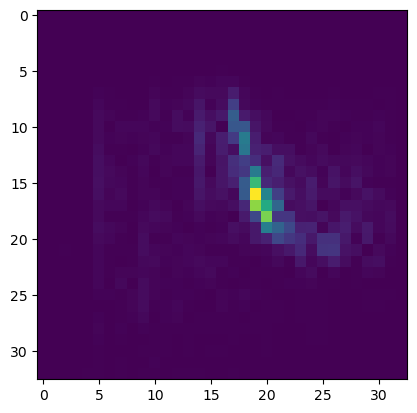

In [38]:
plt.imshow(stft_result_amp)

In [39]:
def calculate_mixed_waveforms(pure_waveforms, noisy_waveforms, nperseg=256):
    f, t, pure_stft = stft(pure_waveforms, fs =5., nperseg=nperseg)
    f, t, noisy_stft = stft(noisy_waveforms, fs =5., nperseg=nperseg)
    
    pure_amplitudes = np.absolute(pure_stft)
    noisy_amplitudes = np.absolute(noisy_stft)
    
    pure_phases = np.angle(pure_stft)
    noisy_phases = np.angle(noisy_stft)
    
    t, mixed_waveforms = istft(pure_amplitudes * np.exp(1j*noisy_phases))
    
    return t, mixed_waveforms

In [40]:
a,b,c = stft(pure_waveforms)

In [41]:
t, mixed_waveforms_new = calculate_mixed_waveforms(pure_waveforms, noisy_waveforms, nperseg=256)

In [42]:
mixed_waveforms.shape

(10000, 1024)

In [43]:
t.shape

(10000,)

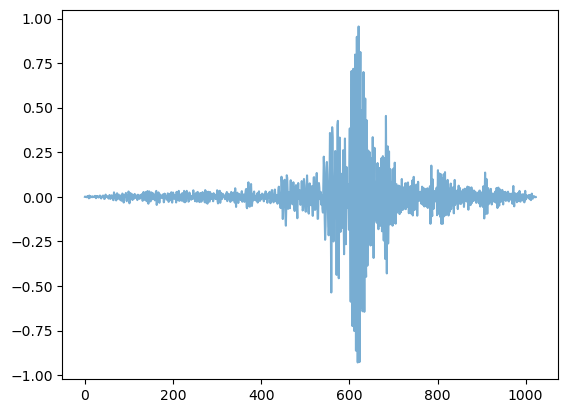

In [44]:
plt.plot(mixed_waveforms_new[0], alpha=0.6)
# plt.plot(pure_waveforms[0], alpha=0.6)

In [45]:
t, mixed_waveforms_32 = calculate_mixed_waveforms(pure_waveforms, noisy_waveforms, nperseg=32)
t, mixed_waveforms_256 = calculate_mixed_waveforms(pure_waveforms, noisy_waveforms, nperseg=256)

In [46]:
test_comparison_32 = StftComparison(pure_waveforms, mixed_waveforms_32)
test_comparison_256 = StftComparison(pure_waveforms, mixed_waveforms_256)

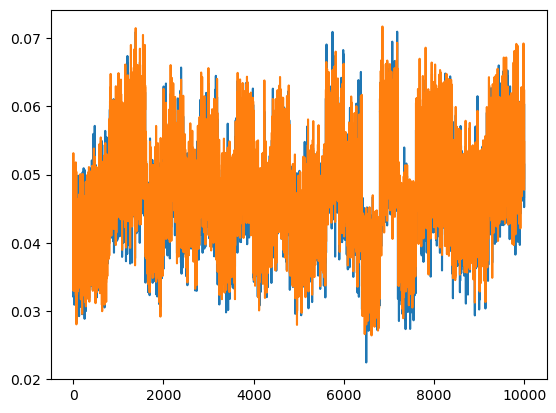

In [47]:
plt.plot(test_comparison_32.difference_mean)
plt.plot(test_comparison_256.difference_mean)

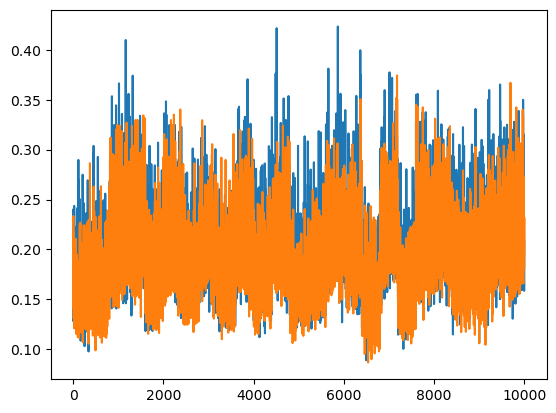

In [48]:
plt.plot(test_comparison_32.difference_max)
plt.plot(test_comparison_256.difference_max)

### Discussion
Reducing the segment size does not have a significant influence on the quality of the data. The mixed waveform, using noisy phase and perfectly denoised amplitude, is not highly affected by a reduced segment size.

This is not necessarily surprising given the fact that the number of variables stays the same in each case. By reducing the segmentsize, therefore using more segments to split up the waveform, the frequency resolution is decreased. Ignoring this effect can only be done by using higher overlap between time segments. When doing this however, one needs to take into account the Nonzero Overlap Add (NOLA) condition.

This condition relates the windowing method, the segment size and the overlap between these segment sizes and is not trivial to check (in the sense that you cannot immediately tell by looking at the parameters). However, a specific function within scipy exists to do that.


# Methods to estimate phase change
Looking at the most relevant phases - as determined by amplitude size - might give new clues as to whether a simple statistically based estimation of phase change might be useful.

In [49]:
noisy_amplitudes.mean(axis=0).shape

(129, 9)

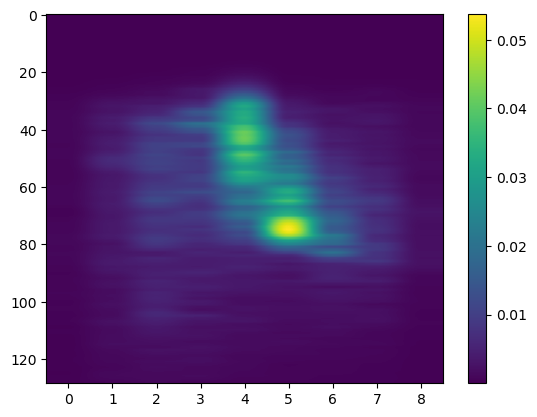

In [50]:
plt.imshow(pure_amplitudes.mean(axis=0), aspect="auto")
plt.colorbar()

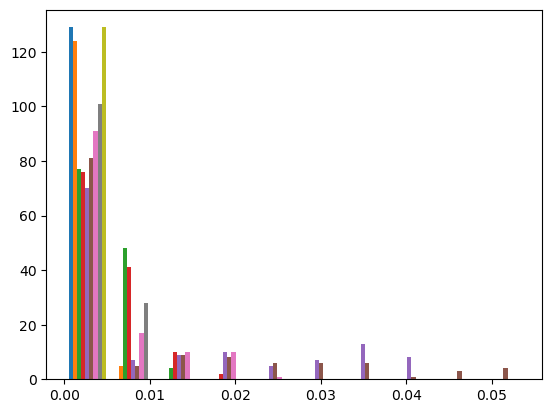

In [51]:
plt.hist(pure_amplitudes.mean(axis=0))
plt.show()

(array([[129.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [129.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [129.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [129.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [105.,  19.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 94.,  12.,   5.,   5.,   5.,   0.,   2.,   4.,   0.,   2.],
        [123.,   4.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [128.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [129.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([9.93669846e-09, 1.16640009e-02, 2.33279919e-02, 3.49919829e-02,
        4.66559738e-02, 5.83199648e-02, 6.99839558e-02, 8.16479467e-02,
        9.33119377e-02, 1.04975929e-01, 1.16639920e-01]),
 <a list of 9 BarContainer objects>)

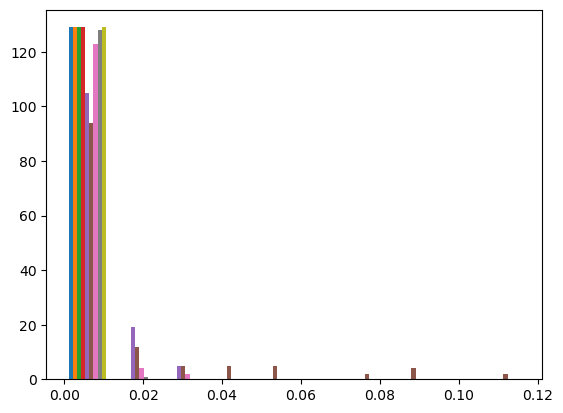

In [52]:
plt.hist(pure_amplitudes[10])

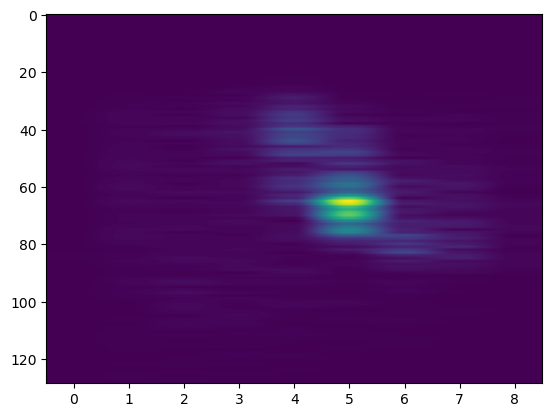

In [53]:
plt.imshow(pure_amplitudes[0], aspect="auto")



### Subset selection
In this section a smaller subset of the STFT is selected to be used in further analysis.
This subset selection simplifies the further analysis.

In [54]:
# index estimates
index_frequencies = [30, 90]
index_timesegments = [3, 7]

In [55]:
pure_reduced_amplitudes = pure_amplitudes[:, index_frequencies[0] : index_frequencies[1], index_timesegments[0]: index_timesegments[1]]
pure_reduced_phases = pure_phases[:, index_frequencies[0] : index_frequencies[1], index_timesegments[0]: index_timesegments[1]]

noisy_reduced_amplitudes = noisy_amplitudes[:, index_frequencies[0] : index_frequencies[1], index_timesegments[0]: index_timesegments[1]]
noisy_reduced_phases = noisy_phases[:, index_frequencies[0] : index_frequencies[1], index_timesegments[0]: index_timesegments[1]]

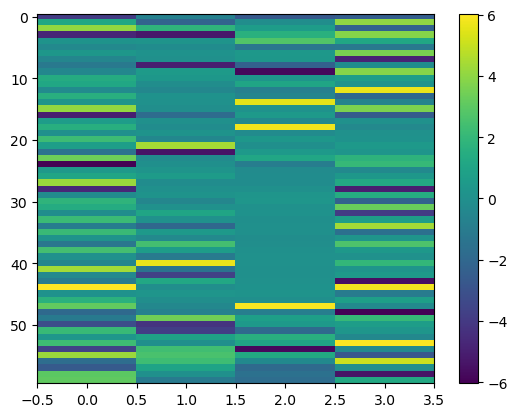

In [56]:
index = 115
plt.imshow(pure_reduced_phases[index] - noisy_reduced_phases[index], aspect="auto")
plt.colorbar()

In [57]:
# plt.imshow(

In [58]:
phase_diff_mean = (pure_reduced_phases-noisy_reduced_phases).mean(axis=0)
phase_diff_var = (pure_reduced_phases-noisy_reduced_phases).var(axis=0)

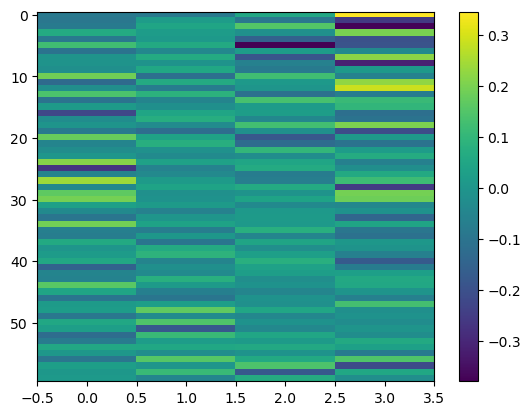

In [59]:
plt.imshow(phase_diff_mean, aspect="auto")
plt.colorbar()

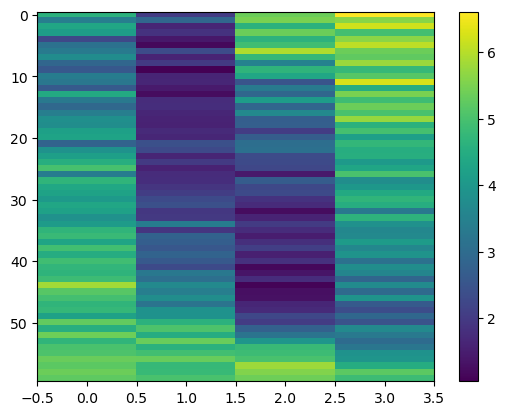

In [60]:
plt.imshow(phase_diff_var, aspect="auto")
plt.colorbar()

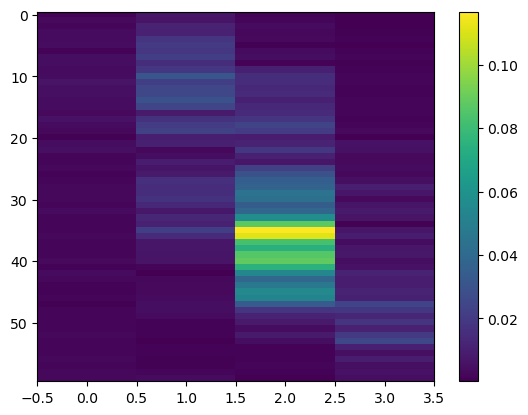

In [72]:
plt.imshow(pure_reduced_amplitudes[0], aspect="auto")
plt.colorbar()
plt.show()

In [70]:
@interact(frequency_index=(0,noisy_reduced_phases.shape[1]-1), time_seg=(0,noisy_reduced_phases.shape[2]-1))
def plot_phase_diff(frequency_index, time_seg):
    plt.plot(noisy_reduced_phases[:,frequency_index,time_seg], pure_reduced_phases[:,frequency_index,time_seg], ".")
    plt.plot(np.linspace(-3,3), np.linspace(-3,3))
    plt.xlabel("noisy phase")
    plt.ylabel("pure phase")

interactive(children=(IntSlider(value=29, description='frequency_index', max=59), IntSlider(value=1, descripti…

In [66]:
@interact(frequency_index=(0,noisy_reduced_phases.shape[1]-1), time_seg=(0,noisy_reduced_phases.shape[2]-1))
def plot_amp_diff(frequency_index, time_seg):
    plt.plot(noisy_reduced_amplitudes[:,frequency_index,time_seg], pure_reduced_amplitudes[:,frequency_index,time_seg], ".")
    plt.xlabel("noisy amplitude")
    plt.ylabel("pure amplitude")
    plt.show()
    # plt.plot(np.linspace(-3,3), np.linspace(-3,3))

interactive(children=(IntSlider(value=29, description='frequency_index', max=59), IntSlider(value=1, descripti…

In [69]:
@interact(frequency_index=(0,noisy_reduced_phases.shape[1]-1), time_seg=(0,noisy_reduced_phases.shape[2]-1))
def plot_amp_diff(frequency_index, time_seg):
    plt.plot(noisy_reduced_amplitudes[:,frequency_index,time_seg], pure_reduced_amplitudes[:,frequency_index,time_seg]/noisy_reduced_amplitudes[:,frequency_index,time_seg], ".")
    plt.ylim((0,5))
    plt.xlabel("noisy amplitude")
    plt.ylabel("pure amplitude")
    # plt.plot(np.linspace(-3,3), np.linspace(-3,3))

interactive(children=(IntSlider(value=29, description='frequency_index', max=59), IntSlider(value=1, descripti…